In [30]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [31]:
# Carga de todos los csv en la carpeta 'mediciones'
files = os.listdir('mediciones')

# Lista de dataframes
dfs = [pd.read_csv('mediciones/' + file) for file in files]

# Nombre de las futuras columnas
columns = [f.replace(".csv", "") for f in files ]


In [32]:
# Verifico que todos los dataframes tengan la misma columna de tiempo
time_cols = [df['time'].tolist() for df in dfs]
for i, time_col in enumerate(time_cols):
    if time_col != time_cols[0]:
        print(f'Dataframe {i} es diferente!')
        break
    else:
        print(f'Df {i} vs 0: Todas las filas son iguales')

Df 0 vs 0: Todas las filas son iguales
Df 1 vs 0: Todas las filas son iguales
Df 2 vs 0: Todas las filas son iguales
Df 3 vs 0: Todas las filas son iguales
Df 4 vs 0: Todas las filas son iguales
Df 5 vs 0: Todas las filas son iguales
Df 6 vs 0: Todas las filas son iguales
Df 7 vs 0: Todas las filas son iguales


In [33]:
# Concatenate all dataframes with first colum 'time' and '(V)' columns
df = pd.concat([df['(V)'] for df in dfs], axis=1)
df.columns = columns
df['time'] = time_cols[0]

# Make 'time' column the index
df.set_index('time', inplace=True)

# Reordeno columnas usando parte numerica del nombre
columns = sorted(columns, key=lambda x: int(x[:-2]))
df = df[columns]

df.head()

,181mm,261mm,552mm,644mm,743mm,839mm,927mm,1042mm
time,,,,,,,,
0.000,0.355050,0.347517,0.357561,0.360072,0.360072,0.360072,0.357561,0.355050
0.005,0.355050,0.355050,0.365094,0.357561,0.367605,0.360072,0.357561,0.357561
0.010,0.355050,0.347517,0.355050,0.367605,0.365094,0.362583,0.357561,0.357561
0.015,0.357561,0.339984,0.357561,0.362583,0.357561,0.357561,0.350028,0.357561
0.020,0.347517,0.355050,0.357561,0.362583,0.355050,0.360072,0.365094,0.357561


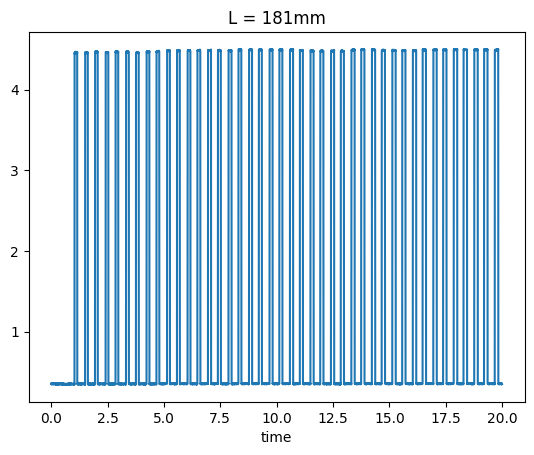

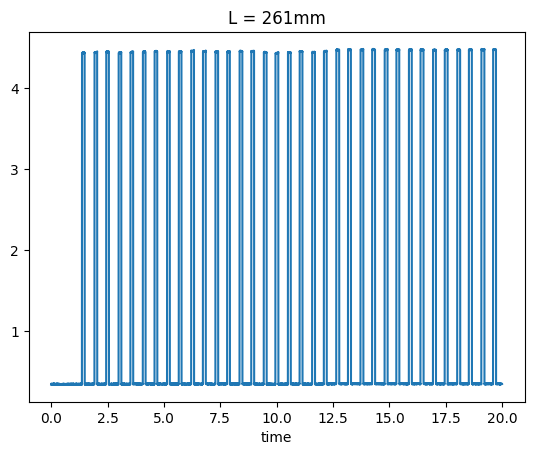

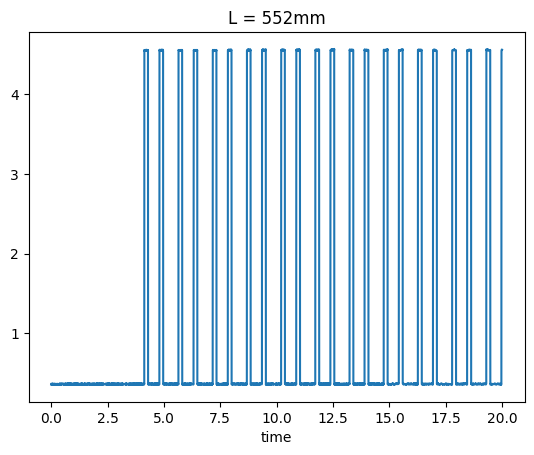

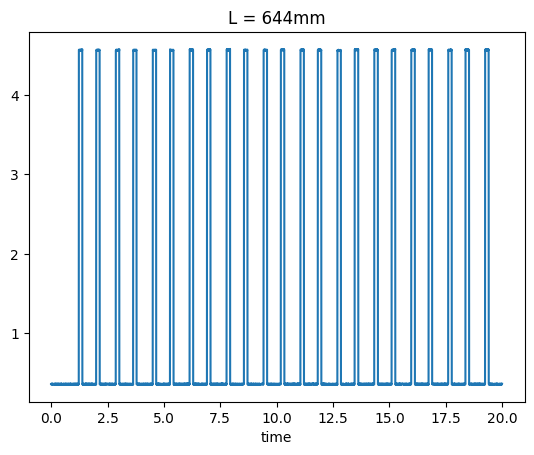

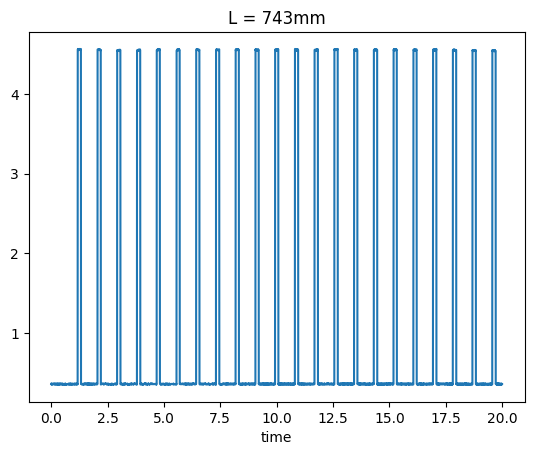

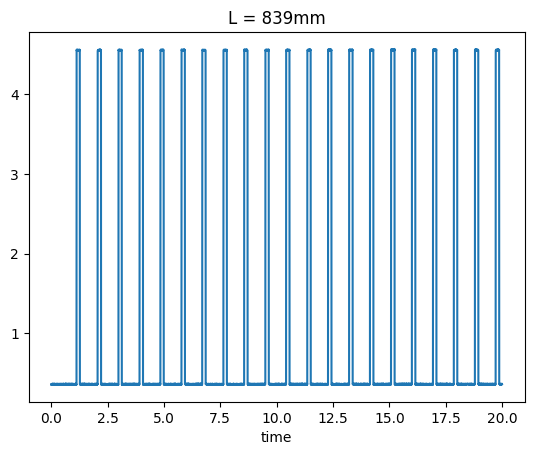

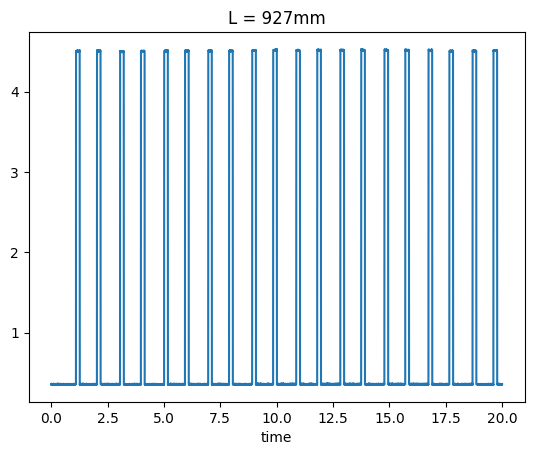

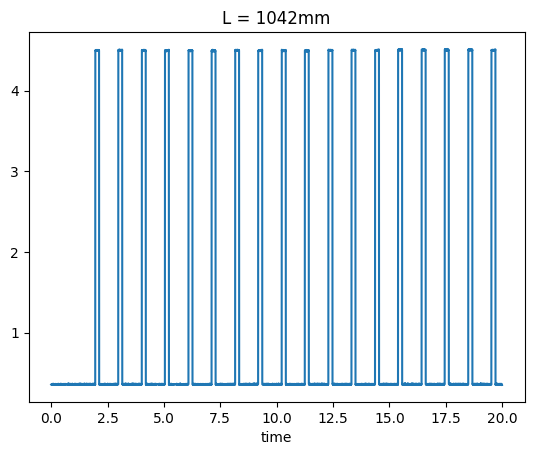

In [39]:
for c in columns:
    df[c].plot()
    plt.title(f"L = {c}")
    plt.show()